### III: Modelling & Tuning

In this notebook, once done with collecting the video and image data, transforming and processing them to coordinates, and doing EDA, we can now proceed with training our binary classification model (define whether good or bad posture). We will explore different type of models, evaluate them and then do hyperparameter tuning to achieve the best scores.

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, make_scorer, roc_curve, auc, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import time
import pickle

import warnings
warnings.filterwarnings("ignore")

In [43]:
df = pd.read_csv('model_df.csv')
df.head()

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,v33,good_posture,left_EyeSH,right_EyeSH,left_ESH,right_ESH,left_NSH,right_NSH,left_SHK,right_SHK
0,Bad,0.597514,0.330045,-0.046739,0.999786,0.595233,0.314657,-0.039935,0.999435,0.594381,...,0.995285,0,155.307020,172.507026,163.510284,178.116644,143.535033,161.939258,147.515758,146.922322
1,Bad,0.603381,0.325570,-0.049170,0.999806,0.601188,0.310604,-0.040726,0.999489,0.600242,...,0.994957,0,163.544608,169.504665,173.068362,179.864711,153.054688,159.226312,149.645177,148.347381
2,Bad,0.614878,0.315903,-0.031407,0.999825,0.613352,0.302009,-0.020730,0.999540,0.612598,...,0.995270,0,169.634487,163.841305,178.625314,173.993331,161.336623,153.260392,150.563715,147.488250
3,Bad,0.624886,0.308227,-0.035477,0.999842,0.623481,0.295145,-0.026631,0.999585,0.622720,...,0.995534,0,164.198492,163.581827,173.384369,173.911822,155.536213,153.985592,155.709640,150.075273
4,Bad,0.636889,0.295799,-0.043732,0.999856,0.634686,0.282637,-0.032385,0.999624,0.634024,...,0.995753,0,161.850092,166.930504,170.893832,176.967896,152.749715,157.711976,158.154844,151.350972


### Import Datasets

In [44]:
df.columns

Index(['class', 'x1', 'y1', 'z1', 'v1', 'x2', 'y2', 'z2', 'v2', 'x3',
       ...
       'v33', 'good_posture', 'left_EyeSH', 'right_EyeSH', 'left_ESH',
       'right_ESH', 'left_NSH', 'right_NSH', 'left_SHK', 'right_SHK'],
      dtype='object', length=142)

In [45]:
X = df[['left_EyeSH', 'right_EyeSH','left_ESH', 'right_ESH', 'left_NSH', 'right_NSH','left_SHK','right_SHK']]
y = df['good_posture']

# commentary / domain knowledge on why these angles are good - straight line?


Steps I took for this section:
1. Train Test Split
2. Create Pipeline for modelling
3. Create Function for Classification Reports
4. Run Different Models
5. Evaluate best model


#### 1. Train Test Split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### 2. Function to define modelling pipeline

In [47]:
# Define pipeline with placeholders

pipeline = ImbPipeline([
    ('ss', StandardScaler()), 
    ('smotetomek', SMOTETomek(random_state=42)),
    ('clf', LogisticRegression()) 
])

#### 3. Function to define Classification Reports

In [48]:
# Generate Classifcation Reports

def report(model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("Classification Report for Train:\n", classification_report(y_train, y_train_pred))
    print("======================================================\n")
    print("Classification Report for Test:\n", classification_report(y_test, y_test_pred))

In [49]:
def run_grid_search(pipeline, param_grid, X_train, y_train):
    grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(10), verbose=1, n_jobs=-1, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    return grid_search

In [50]:
# Define parameter grid

param_grid_logreg = {
    'clf': [LogisticRegression(max_iter = 10000, solver='saga')],
    'clf__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'clf__penalty': ['l1', 'l2']
}

#### 4. Evaluating different classification models

#### 4.1 Baseline Model
We begin with creating a baseline model so that we have something to evaluate our final model against. The baseline model will be using Logistic Regression and all 33 coordinates collected by Mediapipe will be used as features. 

In [51]:
X = df.drop(columns = ['good_posture','class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
baseline_LR = LogisticRegression() 
baseline_LR.fit(X_train, y_train)
score = baseline_LR.score(X_test, y_test)

print(f"Baseline score using Logistic Regression is {score}")

Baseline score using Logistic Regression is 0.9430505774591796


#### 4.2 Logistic Regression

In [52]:
X = df[['left_EyeSH', 'right_EyeSH','left_ESH', 'right_ESH', 'left_NSH', 'right_NSH','left_SHK','right_SHK']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [53]:
# Record the start time
start_time = time.time()

# Run grid search
grid_search_logreg = run_grid_search(pipeline, param_grid_logreg, X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Time needed for run_grid_search: {elapsed_time:.2f} seconds")
print("Best parameters for Logistic Regression:", grid_search_logreg.best_params_)

results_list = []

# Store results in a dictionary
model_results = {
        'Model': 'log_reg',
        'Time': elapsed_time
    }

# Append the results to the list
results_list.append(model_results)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


Time needed for run_grid_search: 2.65 seconds
Best parameters for Logistic Regression: {'clf': LogisticRegression(max_iter=10000, solver='saga'), 'clf__C': 0.5, 'clf__penalty': 'l1'}


In [55]:
# Save the model
LR = grid_search_logreg.best_estimator_

# Generate Classifcation Reports
report(LR)

Classification Report for Train:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93      3006
           1       0.91      0.95      0.93      2852

    accuracy                           0.93      5858
   macro avg       0.93      0.93      0.93      5858
weighted avg       0.93      0.93      0.93      5858


Classification Report for Test:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      1288
           1       0.91      0.94      0.92      1223

    accuracy                           0.92      2511
   macro avg       0.92      0.92      0.92      2511
weighted avg       0.92      0.92      0.92      2511



In [56]:
def cmplot(model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    cm_train = confusion_matrix(y_train, y_train_pred, labels=model.named_steps['clf'].classes_)
    cm_test = confusion_matrix(y_test, y_test_pred, labels=model.named_steps['clf'].classes_)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=model.named_steps['clf'].classes_)
    disp_train.plot(ax=ax[0], cmap=plt.cm.Reds)
    ax[0].set_title('Confusion Matrix for Train Set')
    ax[0].set_xlabel('Predicted Good Pose')
    ax[0].set_ylabel('Actual Good Pose')
    ax[0].set_xticks(ticks=[0, 1])
    ax[0].set_yticks(ticks=[0, 1])

    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=model.named_steps['clf'].classes_)
    disp_test.plot(ax=ax[1], cmap=plt.cm.Blues)
    ax[1].set_title('Confusion Matrix for Test Set')
    ax[1].set_xlabel('Predicted Good Pose')
    ax[1].set_ylabel('Actual Bad Pose')
    ax[1].set_xticks(ticks=[0, 1])
    ax[1].set_yticks(ticks=[0, 1])

    plt.tight_layout()
    plt.show()

In [92]:
results_df = []  # Initialize an empty DataFrame

def class_results(model):

    y_train_prob = model.predict_proba(X_train)[:, 1]
    roc_auc_train = roc_auc_score(y_train, y_train_prob)

    y_test_prob = model.predict_proba(X_test)[:, 1]
    roc_auc_test = roc_auc_score(y_test, y_test_prob)

    # Calculate F1 score and accuracy
    y_train_pred = model.predict(X_train)
    f1_train = f1_score(y_train, y_train_pred)
    accuracy_train = accuracy_score(y_train, y_train_pred)

    y_test_pred = model.predict(X_test)
    f1_test = f1_score(y_test, y_test_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)

    # Prepare data for DataFrame
    model_results = {
        "ROC-AUC Train": roc_auc_train,
        "ROC-AUC Test": roc_auc_test,
        "F1 Train": f1_train,
        "F1 Test": f1_test,
        "Accuracy Train": accuracy_train,
        "Accuracy Test": accuracy_test
    }

    results_df.append(model_results)

    # Print results
    print("ROC-AUC for Train:", roc_auc_train)
    print("ROC-AUC for Test:", roc_auc_test)

    print("F1 for Train:", f1_train)
    print("F1 for Test:", f1_test)

    print("Accuracy for Train:", accuracy_train)
    print("Accuracy for Test:", accuracy_test)


ROC-AUC for Train: 0.959302293029649
ROC-AUC for Test: 0.9530961945729622
F1 for Train: 0.9302325581395349
F1 for Test: 0.922458818802732
Accuracy for Train: 0.9308637760327757
Accuracy for Test: 0.9231381919553963


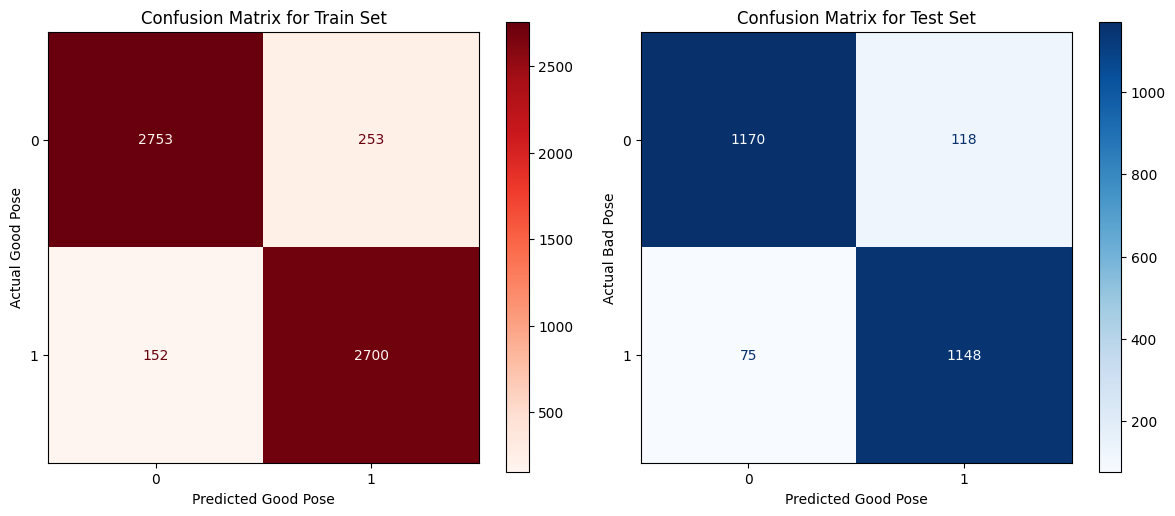

In [93]:
# Results for Logistic Regression
class_results(LR) 
cmplot(LR)

#### 4.2 Random Forest

In [60]:
param_grid_rf = {
    'clf': [RandomForestClassifier()],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__bootstrap': [True, False]
}

In [61]:
# Record the start time
start_time = time.time()

# Run grid search
grid_search_rf = run_grid_search(pipeline, param_grid_rf, X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print output
print(f"Time needed for run_grid_search: {elapsed_time:.2f} seconds")
print("Best parameters for Random Forest:", grid_search_rf.best_params_)


# Store results in a dictionary
model_results = {
        'Model': 'rf',
        'Time': elapsed_time}

# Append the results to the list
results_list.append(model_results)



Fitting 10 folds for each of 32 candidates, totalling 320 fits


Time needed for run_grid_search: 105.28 seconds
Best parameters for Random Forest: {'clf': RandomForestClassifier(), 'clf__bootstrap': False, 'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [62]:
# Save the model

RF = grid_search_rf.best_estimator_

In [95]:
class_results(RF)
report(RF)

ROC-AUC for Train: 0.9998078877308496
ROC-AUC for Test: 0.9989598304749039
F1 for Train: 0.9992989835261129
F1 for Test: 0.9861337683523654
Accuracy for Train: 0.99931717309662
Accuracy for Test: 0.9864595778574273
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3006
           1       1.00      1.00      1.00      2852

    accuracy                           1.00      5858
   macro avg       1.00      1.00      1.00      5858
weighted avg       1.00      1.00      1.00      5858


Classification Report for Test:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1288
           1       0.98      0.99      0.99      1223

    accuracy                           0.99      2511
   macro avg       0.99      0.99      0.99      2511
weighted avg       0.99      0.99      0.99      2511



#### 4.3 K-Nearest Neighbour (KNN)

In [64]:
param_grid_knn = {
    'clf': [KNeighborsClassifier()],
    'clf__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['euclidean', 'manhattan', 'minkowski'],
    'clf__p': [1, 2]  # This is used only when metric is 'minkowski'. p=1 is manhattan, p=2 is euclidean.
}

In [65]:
# Record the start time
start_time = time.time()

# Run grid search
grid_search_knn = run_grid_search(pipeline, param_grid_knn, X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Store results in a dictionary
model_results = {
        'Model': 'knn',
        'Time': elapsed_time}

# Append the results to the list
results_list.append(model_results)

# Print output
print(f"Time needed for run_grid_search: {elapsed_time:.2f} seconds")
print("Best parameters for K-Nearest Neighbour:", grid_search_knn.best_params_)


Fitting 10 folds for each of 84 candidates, totalling 840 fits
Time needed for run_grid_search: 5.57 seconds
Best parameters for K-Nearest Neighbour: {'clf': KNeighborsClassifier(), 'clf__metric': 'manhattan', 'clf__n_neighbors': 15, 'clf__p': 1, 'clf__weights': 'distance'}


In [66]:
# Save the model

KNN = grid_search_knn.best_estimator_

ROC-AUC for Train: 0.9996575339270034
ROC-AUC for Test: 0.997121044372102
F1 for Train: 0.9991235758106923
F1 for Test: 0.9791240278346296
Accuracy for Train: 0.999146466370775
Accuracy for Test: 0.9796893667861409
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3006
           1       1.00      1.00      1.00      2852

    accuracy                           1.00      5858
   macro avg       1.00      1.00      1.00      5858
weighted avg       1.00      1.00      1.00      5858


Classification Report for Test:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1288
           1       0.98      0.98      0.98      1223

    accuracy                           0.98      2511
   macro avg       0.98      0.98      0.98      2511
weighted avg       0.98      0.98      0.98      2511



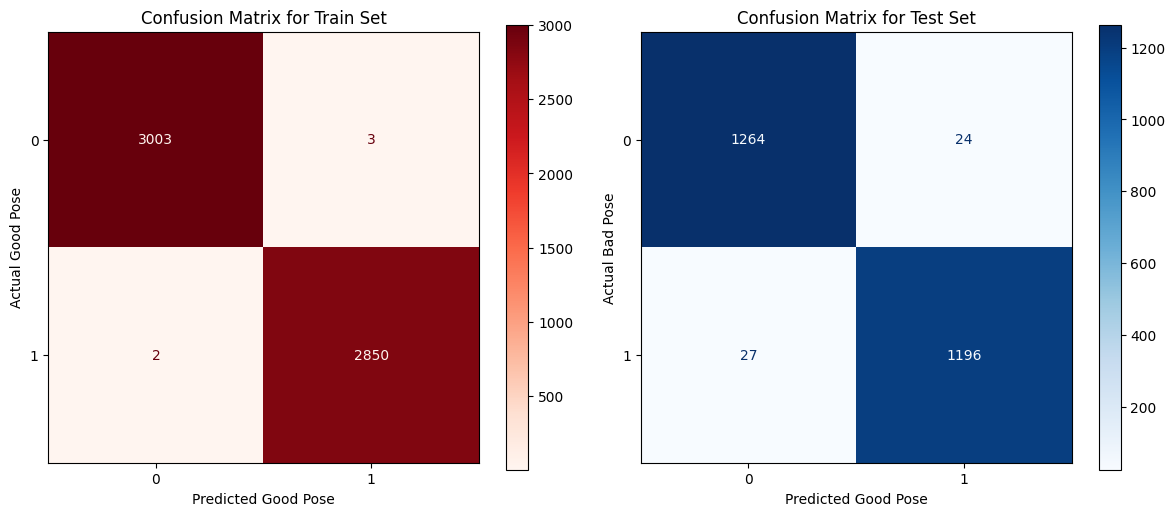

In [96]:
class_results(KNN)
report(KNN)
cmplot(KNN)

#### 4.4 Adaboost

In [68]:
param_grid_ada = {
    'clf': [AdaBoostClassifier()],
    'clf__n_estimators': [10, 50, 100, 200],
    'clf__learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0],
    'clf__algorithm': ['SAMME', 'SAMME.R']
}

In [69]:
# Record the start time
start_time = time.time()

# Run grid search
grid_search_ada = run_grid_search(pipeline, param_grid_ada, X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Store results in a dictionary
model_results = {
        'Model': 'ada',
        'Time': elapsed_time}

# Append the results to the list
results_list.append(model_results)

# Print output
print(f"Time needed for run_grid_search: {elapsed_time:.2f} seconds")
print("Best parameters for AdaBoost:", grid_search_ada.best_params_)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Time needed for run_grid_search: 53.00 seconds
Best parameters for AdaBoost: {'clf': AdaBoostClassifier(), 'clf__algorithm': 'SAMME.R', 'clf__learning_rate': 1.0, 'clf__n_estimators': 200}


In [70]:
# Save the model

AD = grid_search_ada.best_estimator_

ROC-AUC for Train: 0.996176009365094
ROC-AUC for Test: 0.9843641285302915
F1 for Train: 0.9670973298880275
F1 for Test: 0.9464856230031949
Accuracy for Train: 0.9673950153636053
Accuracy for Test: 0.9466348068498606
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97      3006
           1       0.95      0.98      0.97      2852

    accuracy                           0.97      5858
   macro avg       0.97      0.97      0.97      5858
weighted avg       0.97      0.97      0.97      5858


Classification Report for Test:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95      1288
           1       0.93      0.97      0.95      1223

    accuracy                           0.95      2511
   macro avg       0.95      0.95      0.95      2511
weighted avg       0.95      0.95      0.95      2511



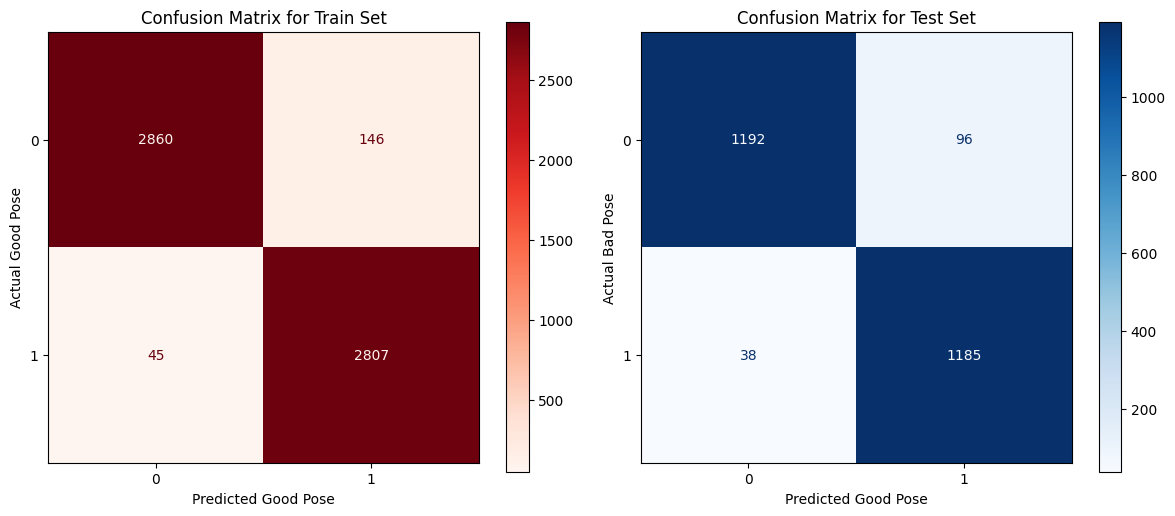

In [97]:
class_results(AD)
report(AD)
cmplot(AD)

#### 4.5 XGBoost

In [76]:
param_grid_xgb = {
    'clf': [XGBClassifier()],
    'clf__learning_rate': [0.01, 0.1],
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [3, 7],
    'clf__min_child_weight': [1, 5],
    'clf__gamma': [0, 0.1],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0],
    'clf__objective': ['binary:logistic']
}

In [77]:
# Record the start time
start_time = time.time()

# Run grid search
grid_search_xgb = run_grid_search(pipeline, param_grid_xgb, X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Store results in a dictionary
model_results = {
        'Model': 'xgb',
        'Time': elapsed_time}

# Append the results to the list
results_list.append(model_results)

# Print output
print(f"Time needed for run_grid_search: {elapsed_time:.2f} seconds")
print("Best parameters for AdaBoost:", grid_search_ada.best_params_)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
Time needed for run_grid_search: 15.57 seconds
Best parameters for AdaBoost: {'clf': AdaBoostClassifier(), 'clf__algorithm': 'SAMME.R', 'clf__learning_rate': 1.0, 'clf__n_estimators': 200}


In [79]:
# Save the model

XGB = grid_search_ada.best_estimator_

ROC-AUC for Train: 0.996176009365094
ROC-AUC for Test: 0.9843641285302915
F1 for Train: 0.9670973298880275
F1 for Test: 0.9464856230031949
Accuracy for Train: 0.9673950153636053
Accuracy for Test: 0.9466348068498606
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97      3006
           1       0.95      0.98      0.97      2852

    accuracy                           0.97      5858
   macro avg       0.97      0.97      0.97      5858
weighted avg       0.97      0.97      0.97      5858


Classification Report for Test:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95      1288
           1       0.93      0.97      0.95      1223

    accuracy                           0.95      2511
   macro avg       0.95      0.95      0.95      2511
weighted avg       0.95      0.95      0.95      2511



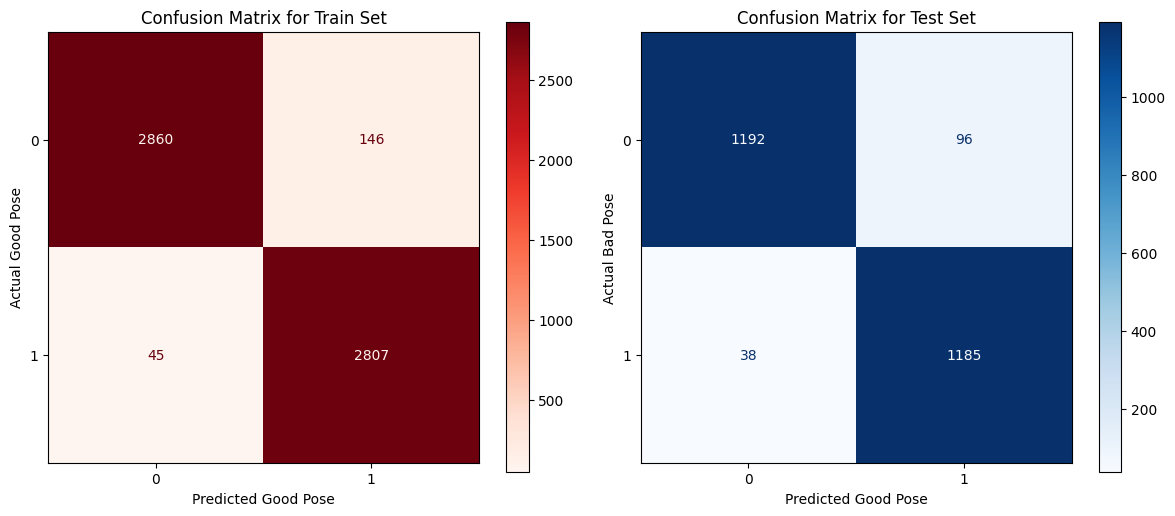

In [98]:
class_results(XGB)
report(XGB)
cmplot(XGB)

In [90]:
results_time = pd.DataFrame(results_list)

#### Model Evaluation + Selection

In [109]:
results_df = pd.DataFrame(results_df)
overall_results = results_time.join(results_df)

In [112]:
overall_results

,Model,Time,ROC-AUC Train,ROC-AUC Test,F1 Train,F1 Test,Accuracy Train,Accuracy Test
0,log_reg,2.652821,0.959302,0.953096,0.930233,0.922459,0.930864,0.923138
1,rf,105.280522,0.999808,0.998960,0.999299,0.986134,0.999317,0.986460
2,knn,5.567713,0.999658,0.997121,0.999124,0.979124,0.999146,0.979689
3,ada,52.998717,0.996176,0.984364,0.967097,0.946486,0.967395,0.946635
4,xgb,15.569625,0.996176,0.984364,0.967097,0.946486,0.967395,0.946635


F1-Score is selected as the evaluation metric 
Using F1-Score as the evaluation metric, the Random Forest model performed the best, followed by K-Nearest Neighbour. However, looking at the time needed to perform Grid Search for RF model (105s) vs KNN model (5.6s), I selected **KNN model** as it is more computationally efficient and has a very impressive F1-score for test data at 0.98 as well.

In summary, the model selected:
- Model: K-Nearest Neighbour
- Best Parameters'clf__metric': 'manhattan', 'clf__n_neighbors': 15, 'clf__p': 1, 'clf__weights': 'distance'

#### Saving and Loading the Trained Model using Pickle

After selecting the final model, I want to deploy it to a Streamlit app for a live demo - hence save it in a pickle file.

In [73]:
# Select the final model
model = KNN

In [74]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
 


In [75]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9864595778574273


#### Conclusion

Summary of Findings

Limitations / Challenges

#### Future Work
1. Deploy to a Phone App: Bring the posture analysis system to a mobile app for widespread accessibility.
2. Prescriptive Messages on How to Improve Posture: Provide actionable advice to users for correcting and improving their posture. Generate personalized, prescriptive messages based on the detected issues. Include visual or textual guidance for corrective exercises or adjustments.
3. Detect Specific Types of Bad Posture/Medical Conditions: Enhance the system to identify and differentiate between specific types of bad posture or potential medical conditions. Train the model on a diverse dataset that includes examples of different posture types and medical conditions. For example, implement classification capabilities to identify overarching, slouching, or other specific issues. Collaborate with healthcare professionals to refine the model for medical conditions.

##### Use Cases

1. Public Exercise Areas (Parks/Stadiums):

- Objective: Remind people to maintain good posture during exercise or physical activities.
- Implementation: Deploy cameras or sensors in public exercise areas to monitor individuals' postures.


2. Schools (Physical Education Classes):

- Objective: Ensure students maintain proper posture during physical education classes to prevent musculoskeletal issues.
- Implementation: Integrate posture analysis into physical education sessions using cameras or wearable devices.

3. Teleconsultation with Doctors/Chiropractors:

- Objective: Support remote healthcare professionals in assessing and advising on posture-related issues.
- Implementation: Use a posture analysis system in conjunction with video conferencing tools. Real-time posture assessment during virtual consultations.
Customizable feedback and exercise recommendations.
Integration with electronic health records for documentation.